In [1]:
from typing import Dict, TypedDict,List
from langgraph.graph import StateGraph, START, END

In [2]:
class AgentState(TypedDict): # State Schema
    message:str

def greeting_node(state: AgentState)-> AgentState:
    """
    Simple node that add a greeting message to state
    """
    state['message']  = "Hey" + state["message"] + ", How are you doing"

    return state


In [3]:
graph = StateGraph(AgentState)

graph.add_node("Greetor", greeting_node)
graph.set_entry_point("Greetor")
graph.set_finish_point("Greetor")

appp = graph.compile()

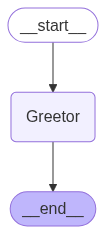

In [4]:
from IPython.display import Image, display
display(Image(appp.get_graph().draw_mermaid_png()))

In [5]:
appp.invoke({"message":'Somesh'})

{'message': 'HeySomesh, How are you doing'}

In [6]:
from typing import List

class AgentState(TypedDict):
    value:List[int]
    name: str
    result: str

In [7]:
def sum_graph(state:AgentState)->AgentState:
    state['result'] = f'Hey my name is {state['name']}. here is the sum of Values: {sum(state["value"])} '
    return state

In [8]:
builder = StateGraph(AgentState)
builder.add_node('process', sum_graph)
builder.set_entry_point('process')
builder.set_finish_point('process')

app = builder.compile()

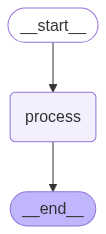

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
from typing import List

class AgentState(TypedDict):
    skills:List[str]
    name: str
    age: int
    result:str

In [11]:
def name_node(state:AgentState)->AgentState:
    state['result'] = f"Hey There! This is {state['name']}."
    return state


def age_node(state:AgentState)->AgentState:
    state['result'] = state['result'] + f" My age is {state['age']}"
    return state

def skill_node(state:AgentState)->AgentState:
    state['result'] = state['result']+ f"Here are my Skills:{state['skills']}"
    return state


In [12]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node('name_node', name_node)
graph_builder.add_node('age_node', age_node)
graph_builder.add_node('skill_node', skill_node)

graph_builder.set_entry_point("name_node")
graph_builder.add_edge("name_node", "age_node")
graph_builder.add_edge("age_node", "skill_node")
graph_builder.set_finish_point("skill_node")

comp_fraph = graph_builder.compile()

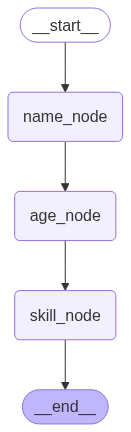

In [13]:
from IPython.display import Image, display
display(Image(comp_fraph.get_graph().draw_mermaid_png()))

In [14]:
comp_fraph.invoke({"name":"Somesh", 'age':29, "skills":['Python',"machine learning",3]})['result']

"Hey There! This is Somesh. My age is 29Here are my Skills:['Python', 'machine learning', 3]"

In [15]:

class AgentState(TypedDict):
    number1: int
    number2: int    
    operation:str
    final_number:int

In [16]:
def add_node(state:AgentState)->AgentState:
    state['final_number']= state['number1'] + state['number2']
    return state

def sub_node(state:AgentState)->AgentState:
    state['final_number']= state['number1'] - state['number2']
    return state

def router(state:AgentState)->AgentState:
    if state['operation']=='+':
        return "addition_operation"
    elif state['operation']=="-" :
        return "substraction_operation"


In [17]:
graph = StateGraph(AgentState)

graph.add_node('add_node_1', add_node)
graph.add_node("sub_node_1", sub_node)
graph.add_node('router_1', lambda state:state)
graph.add_edge(START, "router_1")
graph.add_conditional_edges("router_1", 
                            router,
                            {
                                'addition_operation':'add_node_1',
                                'substraction_operation':'sub_node_1'
                            })

graph.add_node('router_2', lambda state: state)
graph.add_edge('add_node_1', 'router_2')
graph.add_edge('sub_node_1', 'router_2')
graph.add_node('add_node_2', add_node)
graph.add_node("sub_node_2", sub_node)
graph.add_conditional_edges("router_2", 
                            router,
                            {
                                'addition_operation':'add_node_2',
                                'substraction_operation':'sub_node_2'
                            })
graph.add_edge('add_node_2', END)
graph.add_edge('sub_node_2', END)

comp_graph = graph.compile()

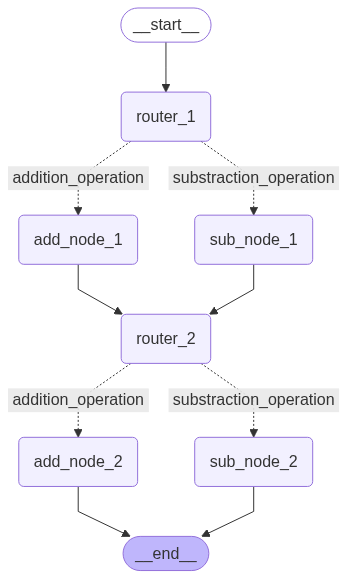

In [18]:
from IPython.display import Image, display
display(Image(comp_graph.get_graph().draw_mermaid_png()))

In [19]:
comp_graph.invoke({'number1': 10,
    'number2': 5,    
    'operation':'-',})  

{'number1': 10, 'number2': 5, 'operation': '-', 'final_number': 5}

In [37]:
import random
class AgentState(TypedDict):
    player_name:str
    lower_bound: int    
    upper_bound:str
    attempts:int
    guesses: List[int]
    target_num : int
    user_input:int

In [38]:

def setup(state:AgentState)->AgentState:
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state['lower_bound'] = 1
    state['upper_bound'] =  20
    state['attempts'] = 0
    state['guesses'] = []
    state["hint"] = "Game started! Try to guess the number."
    state['target_num'] = random.randint(state['lower_bound'], state['upper_bound'])
    return state

In [50]:
def guess(state:AgentState)-> AgentState:
    "guessing the numbers "
    possible_output = [num for num in range(state['lower_bound'],
                                             state['upper_bound']+1)
                                             if num not in state['guesses']]
    if possible_output:
        guess = random.choice(possible_output)
    else:
        guess = random.randint(state['lower_bound'], state['upper_bound'])
    state['guesses'].append(guess)
    state['attempts']+=1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

In [60]:
def hint_node(state:AgentState)->AgentState:
    latest_guess = state['guesses'][-1]
    target = state['target_num']
    if latest_guess<target:
        state['hint'] = f"The number {latest_guess} is lower. try higher"
        state['lower_bound'] = max(state['lower_bound'], latest_guess+1)
        print(f"hint: {state['hint']}")
    elif latest_guess>target:
        state['hint'] = f"The number {latest_guess} is Higher. try lower"
        state['upper_bound'] = min(state['upper_bound'], latest_guess-1)
        print(f"hint: {state['hint']}")
    else:
        state['hint'] = f"You got the {target} in {state['attempts']} attempts"
    return state

In [61]:
def should_continue(state:AgentState)->str:
    latest_guess = state['guesses'][-1]
    if latest_guess==state['target_num']:
        print(f"YaY: You've got the number {latest_guess}")
        return "end"
    elif state['attempts'] >=7:
        print("Numebr of attemtpts are over! game Over We'll not tell ypou the number")
        return "end"
    else:
        print(f"{7-state['attempts']} attempts out of 7 attempts are left")
        return "continue"

In [62]:
graph = StateGraph(AgentState)

graph.add_node('setup', setup)
graph.add_node('guess', guess)
graph.add_node('hint_node', hint_node)


graph.add_edge('setup', 'guess')
graph.add_edge('guess', 'hint_node')

graph.add_conditional_edges('hint_node',
                            should_continue,
                            {"end":END,
                             "continue":'guess'})
graph.set_entry_point('setup')

my_graph = graph.compile()

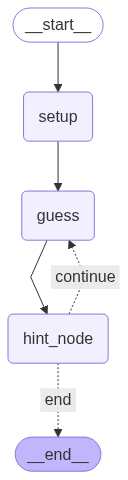

In [63]:
from IPython.display import Image, display
display(Image(my_graph.get_graph().draw_mermaid_png()))

In [67]:
result = my_graph.invoke({"player_name": "Student", "guesses": [],
                           "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Attempt 1: Guessing 10 (Current range: 1-20)
hint: The number 10 is lower. try higher
6 attempts out of 7 attempts are left
Attempt 2: Guessing 15 (Current range: 11-20)
hint: The number 15 is Higher. try lower
5 attempts out of 7 attempts are left
Attempt 3: Guessing 13 (Current range: 11-14)
hint: The number 13 is Higher. try lower
4 attempts out of 7 attempts are left
Attempt 4: Guessing 12 (Current range: 11-12)
hint: The number 12 is Higher. try lower
3 attempts out of 7 attempts are left
Attempt 5: Guessing 11 (Current range: 11-11)
YaY: You've got the number 11


In [68]:
from euriai.langchain import create_chat_model

chat_model = create_chat_model(
    api_key="euri-bc2ae16e7d40c167df6c59920835de0cfaecaf0ba6afe9a88cb64f3b5d13bf9d",
    model="gpt-4.1-nano",
    temperature=0.7
)

response = chat_model.invoke("What is artificial intelligence?")
print(response.content)


ModuleNotFoundError: No module named 'euriai.langchain'

In [84]:
EURI_API = "euri-bc2ae16e7d40c167df6c59920835de0cfaecaf0ba6afe9a88cb64f3b5d13bf9d"

In [85]:
from euriai import EuriaiClient

client = EuriaiClient(
    api_key=EURI_API,
    model="black-forest-labs/FLUX.1-schnell"
)

response = client.generate_completion(
    prompt="Write a short poem about artificial intelligence.",
    temperature=0.7,
    max_tokens=300
)

print(response)

HTTPError: 404 Client Error: Not Found for url: https://api.euron.one/api/v1/euri/alpha/chat/completions